# **Exploring Deprivation and Ethnic Diversity in England and Wales: An LSOA-Level Analysis**

1. [**Introduction**](#1.-Introduction)  
   - [**Overview and Objectives**](#Overview-and-Objectives)  
   - [**Context and Importance**](#Context-and-Importance)  
2. [**Deprivation**](#2.-Deprivation)  
   - [2A **Deprivation: Exploratory Analysis**](#2A-Deprivation:-Exploratory-Analysis)  
   - [2B **Mapping of Deprivation**](#2B-Mapping-of-Deprivation)  
3. [**Ethnicity**](#3.-Ethnicity)  
   - [3A **Ethnicity: Exploratory Analysis**](#3A-Ethnicity:-Exploratory-Analysis)  
   - [3B **Mapping of Ethnicity**](#3B-Mapping-of-Ethnicity)  
   - [3C **Ethnicity & Deprivation: Statistical Tests and Analysis**](#3C-Ethnicity-&-Deprivation:-Statistical-Tests-and-Analysis)  
4. [**Rurality vs Urbanity**](#4.-Rurality-vs-Urbanity)  
   - [4A **Mapping of Rural and Urban Areas**](#4A-Mapping-of-Rural-and-Urban-Areas)  
   - [4B **Intersection Between Rurality, Ethnicity and Deprivation**](#4B-Intersection-Between-Rurality,-Ethnicity-and-Deprivation)  
5. [**Conclusion**](#5.-Conclusion)  
   - [**Key Findings**](#Key-Findings)  
   - [**Implications and Future Directions**](#Implications-and-Future-Directions)  


In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import scipy.stats as stats
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## 1. **Introduction**

### **Overview and Objectives**

### **Context and Importance**

## 2. **Deprivation**

### 2A **Deprivation: Exploratory Analysis**

In [9]:
dep = pd.read_csv('LSOA Deprivation.csv')
new_cols = dep.loc[5].values
dep.columns = new_cols
dep['LSOA Code'] = dep['2021 super output area - lower layer'].str.split(' : ').str[0]
dep['LSOA Name'] = dep['2021 super output area - lower layer'].str.split(' : ').str[1]
dep = dep.drop(columns=['2021 super output area - lower layer'])
dep.set_index('LSOA Code', inplace=True)
dep = dep.iloc[7:-7]
dep.columns = ['Total Households','%','Not-N','Not-%','1-N','1-%','2-N','2-%','3-N','3-%','4-N','4-%','LSOA Name']
dep.drop('%', axis=1, inplace=True)
dep = dep.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name != "LSOA Name" else x)
dep['Deprived %'] = 100 - dep['Not-%']
dep.head()

,Total Households,Not-N,Not-%,1-N,1-%,2-N,2-%,3-N,3-%,4-N,4-%,LSOA Name,Deprived %
LSOA Code,,,,,,,,,,,,,
E01011954,963,389,40.4,304,31.6,207,21.5,62,6.4,1,0.1,Hartlepool 001A,59.6
E01011969,603,306,50.7,199,33.0,89,14.8,9,1.5,0,0.0,Hartlepool 001B,49.3
E01011970,488,251,51.4,170,34.8,61,12.5,6,1.2,0,0.0,Hartlepool 001C,48.6
E01011971,519,325,62.6,147,28.3,45,8.7,2,0.4,0,0.0,Hartlepool 001D,37.4
E01033465,740,459,62.0,209,28.2,66,8.9,6,0.8,0,0.0,Hartlepool 001F,38.0


The cell above initialises the data relating to deprivation into a pandas dataframe, whose first five rows can be seen. Some columns are renamed using a shorthand - 'Not-N' gives the number of households that are not deprived, 'Not-%' gives the percentage of households that are not deprived... '4-%' the percentage of households that are deprived in four measures, etc. The final column, 'Deprived %', gives the percentage of households that are not deprived, and is derived easily from the percentage of households that are not deprived, 'Not-%'.

In [10]:
dep.describe()

,Total Households,Not-N,Not-%,1-N,1-%,2-N,2-%,3-N,3-%,4-N,4-%,Deprived %
count,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,694.749299,335.514465,48.253787,232.468883,33.501396,99.128588,14.281481,26.032519,3.736020,1.604844,0.227024,51.746213
std,144.022827,103.466264,10.725164,53.253826,3.747987,43.698057,5.678830,20.848522,2.884089,2.389340,0.328408,10.725164
min,400.000000,70.000000,13.300000,81.000000,15.800000,9.000000,1.500000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,601.000000,264.000000,40.500000,196.000000,31.200000,66.000000,9.800000,10.000000,1.500000,0.000000,0.000000,43.700000
50%,665.000000,325.000000,49.000000,226.000000,33.700000,93.000000,13.500000,20.000000,2.900000,1.000000,0.100000,51.000000
75%,767.000000,394.000000,56.300000,261.000000,36.000000,127.000000,18.200000,37.000000,5.400000,2.000000,0.300000,59.500000
max,1980.000000,1052.000000,81.000000,723.000000,59.900000,379.000000,37.000000,191.000000,18.500000,35.000000,5.100000,86.700000


The cell above gives the summary statistics for the deprivation dataframe. Note that we have 35,672 pieces of data in total - this number corresponding to the number of LSOAs in England and Wales.

##### Talk about outliers, etc.

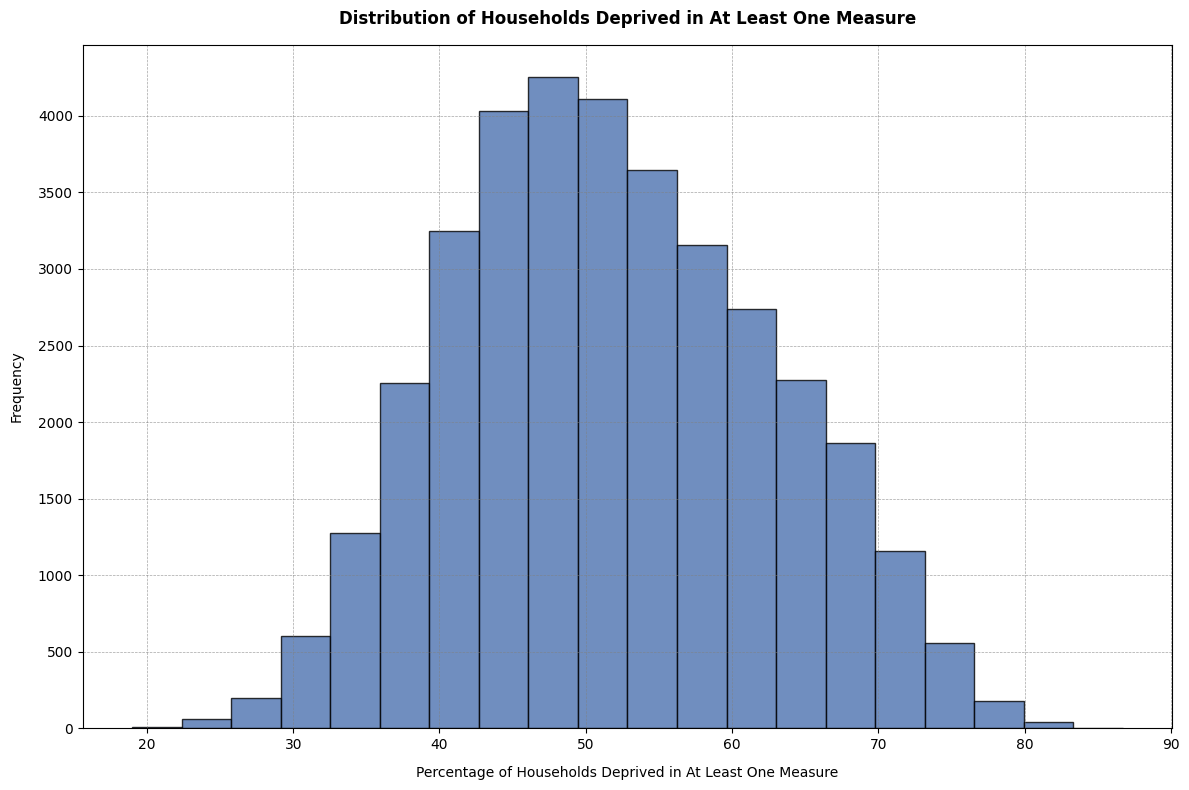

In [11]:
plt.figure(figsize=(12, 8))
plt.hist(dep['Deprived %'], bins=20, edgecolor='black', color='#4c72b0', alpha=0.8)
plt.title('Distribution of Households Deprived in At Least One Measure', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Percentage of Households Deprived in At Least One Measure', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


The cell above outputs the percentage distribution of households deprived in at least one measure. The distribution appears approximately normal, with a single peak near the mean value for the 'Deprived %' column. The summary statistics show that the mean and median values are roughly equal. The distribution appears negatively skewed, indicating that a larger proportion of LSOAs have household deprivation percentages slightly above the mean compared to those below it.

In [12]:
stat, p = normaltest(dep['Deprived %'])
print(f"Test Statistic: {stat}, p-value: {p}")

Test Statistic: 1065.2475837927934, p-value: 4.835331447305942e-232


The cell above implements the Anderson-Darling test for normality. The test was chosen over the Shapiro-Wilk test for its suitability to very large datasets.

Our null hypothesis is to assume that our data on deprivation is normally distributed. The Anderson-Darling test calculates a test statistic, which is the deviation of the emperical cumulative distribution function of our data from the cumulative distribution function for a perfect normal distribution.

The value of the test statistic, 1065.25, is very large, indicating a substantial deviation from normality. The associated p value is effectively zero and therefore far below any conventional threshold. We therefore reject our null hypothesis and infer that the distribution of deprived households in England and Wales' LSOAs is not normally distributed.

### 2B **Mapping of Deprivation**

In [13]:
gdf = gpd.read_file('Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp')
gdf.rename(columns={'LSOA21CD': 'LSOA Code', 'LSOA21NM': 'LSOA Name'}, inplace=True)
gdf.set_index('LSOA Code', inplace=True)
gdf = gdf.to_crs("EPSG:4326")

DataSourceError: Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp: No such file or directory

The cell above initialises the geospatial data relating to LSOAs in England and Wales into a geopandas dataframe. This dataframe can easily have additional data appended to it, allowing for the convenient generation of maps for different variables.

In [20]:
gdf_dep = gdf.merge(dep[['Deprived %']], left_index=True, right_index=True)

Here, the column 'Deprived %' from our deprivation dataframe, giving the percentage of households in an LSOA that are deprived in at least one measure, is appended to the geopandas dataframe. And the cell below generates a geospatial plot of 'Deprived %' for all LSOAs in England and Wales.

In [ ]:
# Bin the 'Deprived %' column
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
gdf_dep['Tot_bin'] = pd.cut(gdf_dep['Deprived %'], bins=bins, labels=labels)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))
gdf_dep.plot(
    column='Tot_bin',
    ax=ax,
    legend=True,
    cmap='RdYlGn_r',
    legend_kwds={
        'title': 'Percentage of Deprived Households',
        'loc': 'upper left',
        'fontsize': 10,
        'title_fontsize': 12
    }
)

# Set titles and labels
ax.set_title('Distribution of Deprived Households by Percentage', fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12, labelpad=10)
ax.set_ylabel('Latitude', fontsize=12, labelpad=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


While the majority of LSOAs in England and Wales have relatively low percentages of deprived households - defined here as below 60% - there are notable clusters of LSOAs with significantly higher levels of deprivation. One such cluster is located in southern Wales, between Cardiff and Swansea. Interestingly, LSOAs with deprivation levels between 60% and 90% often lie in close proximity to areas with much lower levels of deprivation. This pattern is also true in the Midlands, the Highlands, and areas in and around Greater London, where patches of high deprivation (red) are surrounded by areas of low deprivation (green).

A different pattern is observed on the eastern coast of the Midlands, which is the largest contiguous cluster of high-deprivation LSOAs in England and Wales (see the patch of red). This area is made up of now forgotten seaside towns like Grimsby,... 

.......

## 3. **Ethnicity**

### 3A **Ethnicity: Exploratory Analysis**

In [ ]:
eth = pd.read_csv('LSOA Ethnicity.csv')
eth.columns = ['LSOA', 'Total', '%', 'Asian', 'Asian %', 'Black', 'Black %', 'Mixed', 'Mixed %', 'White',
               'White %', 'Other', 'Other %']
eth = eth.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name != "LSOA" else x)
eth = eth.iloc[7:-7]
eth['LSOA Code'] = eth['LSOA'].str.split(' : ').str[0]
eth['LSOA Name'] = eth['LSOA'].str.split(' : ').str[1]
eth.drop('%', axis=1, inplace=True)
eth.drop('LSOA', axis=1, inplace=True)
eth.set_index('LSOA Code', inplace=True)
eth['Non-White'] = eth['Total'] - eth['White']
eth['Non-White %'] = 100 - eth['White %']
eth.head()

In [ ]:
eth.describe()

In [ ]:
total = eth['Total'].sum()
total_asian = eth['Asian'].sum()
total_black = eth['Black'].sum()
total_mixed = eth['Mixed'].sum()
total_other = eth['Other'].sum()
total_white = eth['White'].sum()

asian_prop = total_asian / total
black_prop = total_black / total
mixed_prop = total_mixed / total
other_prop = total_other / total
white_prop = total_white / total

print(f"There are {int(total):,} total residents in England and Wales")
print("")
print(f"Asian residents make up a total of {asian_prop * 100:.2f}% of the population, with a total number of {int(total_asian):,} residents")
print(f"Black residents make up a total of {black_prop * 100:.2f}% of the population, with a total number of {int(total_black):,} residents")
print(f"Mixed residents make up a total of {mixed_prop * 100:.2f}% of the population, with a total number of {int(total_mixed):,} residents")
print(f"Other residents make up a total of {other_prop * 100:.2f}% of the population, with a total number of {int(total_other):,} residents")
print(f"White residents make up a total of {white_prop * 100:.2f}% of the population, with a total number of {int(total_white):,} residents")


In [ ]:
totals = [total_asian, total_black, total_mixed, total_other, total_white]
ethnicities = ["Asian", "Black", "Mixed", "Other", "White"]

plt.figure(figsize=(8, 5))
bars = plt.bar(ethnicities, totals, color=['blue', 'green', 'orange', 'purple', 'red'])

for bar, total in zip(bars, totals):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(total):,}', ha='center', va='bottom', fontsize=10)

plt.xlabel("Ethnicity", fontsize=10)
plt.ylabel("Total Population", fontsize=10)
plt.title("Total Population by Ethnicity in England and Wales", fontsize=13, fontweight='bold', pad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eth['White %'], bins=20, edgecolor='black', color='#4c72b0')
plt.title('Distribution of White Residents', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of White Residents', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eth['Black %'], bins=20, edgecolor='black', color='#4c72b0')
plt.title('Distribution of Black Residents', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of Black Residents', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eth['Asian %'], bins=20, edgecolor='black', color='#4c72b0')
plt.title('Distribution of Asian Residents', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of Asian Residents', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eth['Non-White %'], bins=20, edgecolor='black', color='#4c72b0')
plt.title('Percentage of Non-White Residents Across All LSOAs', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of Non-White Residents', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### 3B **Mapping of Ethnicity**

In [ ]:
gdf_eth_NW = gdf.merge(eth[['Non-White %']], left_index=True, right_index=True)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
gdf_eth_NW['NW_bin'] = pd.cut(gdf_eth_NW['Non-White %'], bins=bins, labels=labels)

fig, ax = plt.subplots(figsize=(12, 8))
gdf_eth_NW.plot(column='NW_bin', ax=ax, legend=True, cmap='plasma',
                legend_kwds={'title': 'Non-White Residents (%)', 'loc': 'upper left', 'fontsize': 8, 'title_fontsize': 10, 'frameon': True, 'bbox_to_anchor': (0.02, 0.95)})
ax.set_title('Distribution of Non-White Residents by Percentage', fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12, labelpad=10)
ax.set_ylabel('Latitude', fontsize=12, labelpad=10)
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


### 3C **Ethnicity & Deprivation: Statistical Tests and Analysis**

In [ ]:
cols_dep = ['LSOA Name', 'Total Households', 'Deprived %']
cols_eth = ['Total', 'White %', 'Mixed %', 'Black %', 'Asian %', 'Other %', 'Non-White %']

df = pd.merge(dep[cols_dep], eth[cols_eth], left_index=True, right_index=True)
df = df[['LSOA Name','Total','Total Households','Deprived %','White %','Mixed %','Black %','Asian %','Other %','Non-White %']]
df.head()

In [ ]:
corr_matrix = df.drop('LSOA Name', axis=1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold', pad=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Black %'], df['Deprived %'], alpha=0.3, c='blue', s=10, edgecolor='w', linewidth=0.5)
plt.title('Black Residents vs Deprived Households', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of Black Residents', fontsize=12)
plt.ylabel('Percentage of Deprived Households', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
corr_coeff, p_val = stats.pearsonr(df['Black %'], df['Deprived %'])
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"Coefficient of determination: {corr_coeff**2}")
print(f"P-value: {p_val}")

In [ ]:
X = sm.add_constant(df['Black %'])
y = df['Deprived %']
model = sm.OLS(y, X).fit()

print(f"Coefficient: {model.params.iloc[1]:.4f}")
print(f"P-value: {model.pvalues.iloc[1]:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Asian %'], df['Deprived %'], alpha=0.3, c='blue', s=10, edgecolor='w', linewidth=0.5)
plt.title('Asian Residents vs Deprived Households', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of Asian Residents', fontsize=12)
plt.ylabel('Percentage of Deprived Households', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
corr_coeff, p_val = stats.pearsonr(df['Asian %'], df['Deprived %'])
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"Coefficient of determination: {corr_coeff**2}")
print(f"P-value: {p_val}")

In [ ]:
X = sm.add_constant(df['Asian %'])
y = df['Deprived %']
model = sm.OLS(y, X).fit()

print(f"Coefficient: {model.params.iloc[1]:.4f}")
print(f"P-value: {model.pvalues.iloc[1]:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Non-White %'], df['Deprived %'], alpha=0.3, c='blue', s=10, edgecolor='w', linewidth=0.5)
plt.title('Non-White Residents vs Deprived Households', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of Non-White Residents', fontsize=12)
plt.ylabel('Percentage of Deprived Households', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
corr_coeff, p_val = stats.pearsonr(df['Non-White %'], df['Deprived %'])
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"Coefficient of determination: {corr_coeff**2}")
print(f"P-value: {p_val}")

In [ ]:
X = sm.add_constant(df['Non-White %'])
y = df['Deprived %']
model = sm.OLS(y, X).fit()

print(f"Coefficient: {model.params.iloc[1]:.4f}")
print(f"P-value: {model.pvalues.iloc[1]:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['White %'], df['Deprived %'], alpha=0.3, c='blue', s=10, edgecolor='w', linewidth=0.5)
plt.title('White Residents vs Deprived Households', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of White Residents', fontsize=12)
plt.ylabel('Percentage of Deprived Households', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
corr_coeff, p_val = stats.pearsonr(df['White %'], df['Deprived %'])
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"Coefficient of determination: {corr_coeff**2}")
print(f"P-value: {p_val}")

In [ ]:
X = sm.add_constant(df['White %'])
y = df['Deprived %']
model = sm.OLS(y, X).fit()

print(f"Coefficient: {model.params.iloc[1]:.4f}")
print(f"P-value: {model.pvalues.iloc[1]:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['White %'], df['Deprived %'], alpha=0.03, c='blue', s=10, edgecolor='w', linewidth=0.5)
plt.title('White Residents vs Deprived Households', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Percentage of White Residents', fontsize=12)
plt.ylabel('Percentage of Deprived Households', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=21, random_state=0)
df['KMeans Cluster'] = kmeans.fit_predict(df[['White %', 'Deprived %']])

cluster_means = df.groupby('KMeans Cluster')[['White %', 'Deprived %']].mean()
sorted_clusters = cluster_means.sort_values(by='White %').index
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
df['Cluster'] = df['KMeans Cluster'].map(cluster_mapping)

plt.figure(figsize=(10, 6))
plt.scatter(df['White %'], df['Deprived %'], c=df['Cluster'], cmap='Spectral', s=10, alpha=0.5)
plt.title('KMeans Clustering of White % vs Deprivation %')
plt.xlabel('White %')
plt.ylabel('Deprived %')
plt.grid(True)

for cluster, (x, y) in cluster_means.iterrows():
    sorted_cluster = cluster_mapping[cluster]
    plt.text(x, y, str(sorted_cluster), fontsize=8, ha='center', va='center', color='black', fontweight='bold')

plt.show()

df.drop(columns=['KMeans Cluster'], inplace=True)

In [ ]:
gdf_cluster = gdf.merge(df[['Cluster']], left_index=True, right_index=True)
gdf_cluster['Cluster'] = gdf_cluster['Cluster'].astype('category').cat.codes

fig, ax = plt.subplots(figsize=(10, 8))
gdf_cluster.plot(column='Cluster', cmap='Spectral', ax=ax, legend=False)

handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Spectral(c / gdf_cluster['Cluster'].nunique()), markersize=8)
    for c in sorted(gdf_cluster['Cluster'].unique())
]
ax.legend(handles, [f'Cluster {c}' for c in sorted(gdf_cluster['Cluster'].unique())], title="Cluster", loc='upper left', fontsize=8, title_fontsize=10)

ax.set(title='Geographical Distribution of Clusters', xlabel='Longitude', ylabel='Latitude')
plt.tight_layout()
plt.show()

In [ ]:
lsoa_counts = df.groupby('Cluster').size()

total_population = df.groupby('Cluster')['Total'].sum()

overall_population = total_population.sum()
population_proportions = total_population / overall_population

df['White Residents'] = df['White %'] / 100 * df['Total']
white_residents = df.groupby('Cluster')['White Residents'].sum()
white_proportions = white_residents / total_population

df['Deprived Households'] = df['Deprived %'] / 100 * df['Total Households']

deprived_households = df.groupby('Cluster')['Deprived Households'].sum()
total_households_per_cluster = df.groupby('Cluster')['Total Households'].sum()

deprived_proportions = deprived_households / total_households_per_cluster

df['Black Residents'] = df['Black %'] / 100 * df['Total']
black_residents = df.groupby('Cluster')['Black Residents'].sum()
black_proportions = black_residents / total_population

df['Asian Residents'] = df['Asian %'] / 100 * df['Total']
asian_residents = df.groupby('Cluster')['Asian Residents'].sum()
asian_proportions = asian_residents / total_population

df['Mixed Residents'] = df['Mixed %'] / 100 * df['Total']
mixed_residents = df.groupby('Cluster')['Mixed Residents'].sum()
mixed_proportions = mixed_residents / total_population

df['Other Residents'] = df['Other %'] / 100 * df['Total']
other_residents = df.groupby('Cluster')['Other Residents'].sum()
other_proportions = other_residents / total_population

cluster_summary = pd.DataFrame({
    'LSOA Counts': lsoa_counts,
    'Total Population': total_population,
    'Population Proportion': population_proportions,
    'White Proportion': white_proportions,
    'Black Proportion': black_proportions,
    'Asian Proportion': asian_proportions,
    'Mixed Proportion': mixed_proportions,
    'Other Proportion': other_proportions,
    'Deprived Proportion': deprived_proportions
})

cluster_summary

In [ ]:
selected_clusters = [0, 1, 3, 7, 11, 16]

cmap = LinearSegmentedColormap.from_list("custom_gradient", ['#FFFF00', '#FF4500', '#800080', '#0000FF'], N=len(selected_clusters))
colors = [cmap(i / (len(selected_clusters) - 1)) for i in range(len(selected_clusters))]
color_map = {cluster: color for cluster, color in zip(selected_clusters, colors)}
default_color = '#D3D3D3'

gdf_cluster['Color'] = gdf_cluster['Cluster'].apply(lambda x: color_map[x] if x in selected_clusters else default_color)

fig, ax = plt.subplots(figsize=(10, 8))
gdf_cluster.plot(color=gdf_cluster['Color'], ax=ax, legend=False)
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c], markersize=8)
    for c in selected_clusters
]
ax.legend(handles, [f'Cluster {c}' for c in selected_clusters], title="Cluster", loc='upper left', fontsize=8, title_fontsize=10)
ax.set(title='Geographical Distribution of Selected Clusters', xlabel='Longitude', ylabel='Latitude')
plt.tight_layout()
plt.show()

In [ ]:
# from matplotlib.lines import Line2D
# from matplotlib.colors import LinearSegmentedColormap

# # Ensure the geometry is in WGS 84 (EPSG:4326)
# if gdf_cluster.crs != "EPSG:4326":
#     gdf_cluster = gdf_cluster.to_crs("EPSG:4326")

# # Color settings
# selected_clusters = [0, 1, 3, 7, 11, 16]
# cmap = LinearSegmentedColormap.from_list("custom_gradient", ['#FFFF00', '#FF4500', '#800080', '#0000FF'], N=len(selected_clusters))
# colors = [cmap(i / (len(selected_clusters) - 1)) for i in range(len(selected_clusters))]
# color_map = {cluster: color for cluster, color in zip(selected_clusters, colors)}
# default_color = '#D3D3D3'

# # Assign colors based on clusters
# gdf_cluster['Color'] = gdf_cluster['Cluster'].apply(lambda x: color_map[x] if x in selected_clusters else default_color)

# # Create the plot
# fig, ax = plt.subplots(figsize=(10, 8))
# gdf_cluster.plot(color=gdf_cluster['Color'], ax=ax, legend=False)

# # Add custom legend
# handles = [
#     Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c], markersize=8)
#     for c in selected_clusters
# ]
# ax.legend(handles, [f'Cluster {c}' for c in selected_clusters], title="Cluster", loc='upper left', fontsize=8, title_fontsize=10)

# # Set titles and labels
# ax.set_title('Geographical Distribution of Selected Clusters', fontsize=15, fontweight='bold', pad=15)
# ax.set_xlabel('Longitude', fontsize=12, labelpad=10)
# ax.set_ylabel('Latitude', fontsize=12, labelpad=10)

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()


In [ ]:
filtered_gdf_cluster = gdf_cluster[(gdf_cluster['LONG'] >= -2.5) & (gdf['LONG'] <= -1.7) & 
                   (gdf['LAT'] >= 52.3) & (gdf['LAT'] <= 52.7)]

In [ ]:
filtered_gdf_cluster = filtered_gdf_cluster[['LSOA Name', 'geometry', 'Cluster']]
filtered_gdf_cluster.head()

In [ ]:
import folium
m = filtered_gdf_cluster.explore(column='Cluster', name='Cluster')
folium.LayerControl().add_to(m)
m

In [ ]:
threshold = 0.6

above_threshold = cluster_summary[cluster_summary['Deprived Proportion'] > threshold]
below_threshold = cluster_summary[cluster_summary['Deprived Proportion'] <= threshold]

ethnic_proportions = {
    'Ethnicity': ['White', 'Black', 'Asian', 'Mixed', 'Other'],
    'Above Threshold': [
        above_threshold['White Proportion'].mean(),
        above_threshold['Black Proportion'].mean(),
        above_threshold['Asian Proportion'].mean(),
        above_threshold['Mixed Proportion'].mean(),
        above_threshold['Other Proportion'].mean(),
    ],
    'Below Threshold': [
        below_threshold['White Proportion'].mean(),
        below_threshold['Black Proportion'].mean(),
        below_threshold['Asian Proportion'].mean(),
        below_threshold['Mixed Proportion'].mean(),
        below_threshold['Other Proportion'].mean(),
    ]
}

ethnic_proportions_df = pd.DataFrame(ethnic_proportions)

ethnic_proportions_df

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format

threshold = 60
above_threshold_mask = df['Deprived %'] > threshold
below_threshold_mask = df['Deprived %'] <= threshold

above_totals = {
    'White': (df.loc[above_threshold_mask, 'Total'] * df.loc[above_threshold_mask, 'White %'] / 100).sum(),
    'Black': (df.loc[above_threshold_mask, 'Total'] * df.loc[above_threshold_mask, 'Black %'] / 100).sum(),
    'Asian': (df.loc[above_threshold_mask, 'Total'] * df.loc[above_threshold_mask, 'Asian %'] / 100).sum(),
    'Mixed': (df.loc[above_threshold_mask, 'Total'] * df.loc[above_threshold_mask, 'Mixed %'] / 100).sum(),
    'Other': (df.loc[above_threshold_mask, 'Total'] * df.loc[above_threshold_mask, 'Other %'] / 100).sum(),
}
below_totals = {
    'White': (df.loc[below_threshold_mask, 'Total'] * df.loc[below_threshold_mask, 'White %'] / 100).sum(),
    'Black': (df.loc[below_threshold_mask, 'Total'] * df.loc[below_threshold_mask, 'Black %'] / 100).sum(),
    'Asian': (df.loc[below_threshold_mask, 'Total'] * df.loc[below_threshold_mask, 'Asian %'] / 100).sum(),
    'Mixed': (df.loc[below_threshold_mask, 'Total'] * df.loc[below_threshold_mask, 'Mixed %'] / 100).sum(),
    'Other': (df.loc[below_threshold_mask, 'Total'] * df.loc[below_threshold_mask, 'Other %'] / 100).sum(),
}
ethnic_totals_df = pd.DataFrame({
    'Ethnicity': ['White', 'Black', 'Asian', 'Mixed', 'Other'],
    'Above Threshold': list(above_totals.values()),
    'Below Threshold': list(below_totals.values()),
})

ethnic_totals_df.set_index('Ethnicity', inplace=True)
print(ethnic_totals_df)

pd.reset_option('display.float_format')

In [ ]:
print(f"{(ethnic_totals_df.loc['White', 'Above Threshold'] / ethnic_totals_df.loc['White'].sum())*100:.2f}% of White residents live in very deprived LSOAs")
print(f"{(ethnic_totals_df.loc['Black', 'Above Threshold'] / ethnic_totals_df.loc['Black'].sum())*100:.2f}% of Black residents live in very deprived LSOAs")
print(f"{(ethnic_totals_df.loc['Asian', 'Above Threshold'] / ethnic_totals_df.loc['Asian'].sum())*100:.2f}% of Asian residents live in very deprived LSOAs")
print(f"{(ethnic_totals_df.loc['Mixed', 'Above Threshold'] / ethnic_totals_df.loc['Mixed'].sum())*100:.2f}% of Mixed residents live in very deprived LSOAs")
print(f"{(ethnic_totals_df.loc['Other', 'Above Threshold'] / ethnic_totals_df.loc['Other'].sum())*100:.2f}% of Other residents live in very deprived LSOAs")
print("")
print(f"Cumulatively, {(ethnic_totals_df['Above Threshold'].sum()/ethnic_totals_df.sum().sum())*100:.2f}% of residents lived in deprived LSOAs")

## 4. **Rurality vs Urbanity**

In [ ]:
rur_urb = pd.read_csv('LSOA Rural-Urban Classification 2011.csv')
rur_urb.drop('FID', axis=1, inplace=True)
rur_urb.drop('RUC11CD', axis=1, inplace=True)
rur_urb.columns = ['LSOA Code', 'LSOA Name', 'Classification']
rur_urb.set_index('LSOA Code', inplace=True)

rur_urb.head()

In [ ]:
rur_urb.info()

In [ ]:
rur_urb['Classification'].unique()

1. Urban major conurbation
2. Urban city and town
3. Urban minor conurbation
4. Urban city and town in a sparse setting
5. Rural town and fringe
6. Rural town and fringe in a sparse setting
7. Rural village and dispersed
8. Rural village and dispersed in a sparse setting

In [ ]:
df.info()

In [ ]:
df.drop(['White Residents', 'Deprived Households', 'Black Residents', 'Asian Residents', 'Mixed Residents', 'Other Residents'], axis=1, inplace=True)
df = df.merge(rur_urb[['Classification']], how='left', left_index=True, right_index=True)
df.head()

In [ ]:
df.info()

In [ ]:
lsoas_with_nan = df[df['Classification'].isna()]
modal_classification = df.groupby(df['LSOA Name'].str.split().str[0])['Classification'].agg(lambda x: x.mode().iloc[0])
df.loc[df['Classification'].isna(), 'Classification'] = df.loc[df['Classification'].isna(), 'LSOA Name'].str.split().str[0].map(modal_classification)
df['Rural or Urban'] = df['Classification'].str.split().str[0]
df.head()

In [ ]:
df.info()

In [ ]:
df['Classification'].value_counts()

In [ ]:
df['Rural or Urban'].value_counts()

### 4A **Mapping of Rural and Urban Areas**

In [ ]:
gdf_rur_urb =  gdf.merge(df[['Classification']], left_index=True, right_index=True)
classification_colors = {
    'Urban major conurbation': '#333333',
    'Urban city and town': '#666666',      
    'Urban minor conurbation': '#999999',
    'Urban city and town in a sparse setting': '#B3B3B3', 
    'Rural town and fringe': '#66C266',   
    'Rural town and fringe in a sparse setting': '#4C9C4C',
    'Rural village and dispersed': '#2F6B2F',
    'Rural village and dispersed in a sparse setting': '#1A4D1A' 
}
fig, ax = plt.subplots(figsize=(10, 8))
gdf_rur_urb.plot(ax=ax, color=gdf_rur_urb['Classification'].map(classification_colors))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in classification_colors.values()]
labels = [str(i+1) for i in range(len(classification_colors))]

ax.legend(handles=handles, labels=labels, title="Classification", loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Geographical Distribution of LSOAs by Urban/Rural Classification", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

### 4B **Intersection Between Rurality, Ethnicity and Deprivation**

stat. test between ethnicities, and rurality (binary, categorical).
stat. test between rurality and deprivation (continuous)

In [ ]:
rural_white = df[df['Rural or Urban'] == 'Rural']['White %']
urban_white = df[df['Rural or Urban'] == 'Urban']['White %']

plt.figure(figsize=(10, 6))
sns.histplot(rural_white, color='green', label='Rural', kde=True, bins=20, stat='density')
sns.histplot(urban_white, color='blue', label='Urban', kde=True, bins=20, stat='density')
plt.title('Distribution of White % in Rural and Urban Areas')
plt.xlabel('White %')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
rural_black = df[df['Rural or Urban'] == 'Rural']['Non-White %']
urban_black = df[df['Rural or Urban'] == 'Urban']['Non-White %']

plt.figure(figsize=(10, 6))
sns.histplot(rural_black, color='green', label='Rural', kde=True, bins=20, stat='density')
sns.histplot(urban_black, color='blue', label='Urban', kde=True, bins=20, stat='density')
plt.title('Distribution of Non-White % in Rural and Urban Areas')
plt.xlabel('Non-White %')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
rural_mask = df['Rural or Urban'] == 'Rural'
urban_mask = df['Rural or Urban'] == 'Urban'

rural_totals = {
    'White': (df.loc[rural_mask, 'Total'] * df.loc[rural_mask, 'White %'] / 100).sum(),
    'Black': (df.loc[rural_mask, 'Total'] * df.loc[rural_mask, 'Black %'] / 100).sum(),
    'Asian': (df.loc[rural_mask, 'Total'] * df.loc[rural_mask, 'Asian %'] / 100).sum(),
    'Mixed': (df.loc[rural_mask, 'Total'] * df.loc[rural_mask, 'Mixed %'] / 100).sum(),
    'Other': (df.loc[rural_mask, 'Total'] * df.loc[rural_mask, 'Other %'] / 100).sum()
}

urban_totals = {
    'White': (df.loc[urban_mask, 'Total'] * df.loc[urban_mask, 'White %'] / 100).sum(),
    'Black': (df.loc[urban_mask, 'Total'] * df.loc[urban_mask, 'Black %'] / 100).sum(),
    'Asian': (df.loc[urban_mask, 'Total'] * df.loc[urban_mask, 'Asian %'] / 100).sum(),
    'Mixed': (df.loc[urban_mask, 'Total'] * df.loc[urban_mask, 'Mixed %'] / 100).sum(),
    'Other': (df.loc[urban_mask, 'Total'] * df.loc[urban_mask, 'Other %'] / 100).sum()
}

rural_urban_totals_df = pd.DataFrame({
    'Ethnicity': ['White', 'Black', 'Asian', 'Mixed', 'Other'],
    'Rural': list(rural_totals.values()),
    'Urban': list(urban_totals.values()),
})

rural_urban_totals_df.set_index('Ethnicity', inplace=True)

rural_urban_totals_df['Rural Proportion'] = rural_urban_totals_df['Rural']/ (rural_urban_totals_df['Rural'] + rural_urban_totals_df['Urban'])
rural_urban_totals_df['Urban Proportion'] = rural_urban_totals_df['Urban']/ (rural_urban_totals_df['Rural'] + rural_urban_totals_df['Urban'])

# rural_urban_totals_df.drop(['Rural', 'Urban'],axis=1, inplace=True)

rural_urban_totals_df['Rural'] = rural_urban_totals_df['Rural'].round(0)
rural_urban_totals_df['Urban'] = rural_urban_totals_df['Urban'].round(0)
rural_urban_totals_df['Rural Proportion'] = rural_urban_totals_df['Rural Proportion'].round(3)
rural_urban_totals_df['Urban Proportion'] = rural_urban_totals_df['Urban Proportion'].round(3)

rural_urban_totals_df

In [ ]:
rural_total = rural_urban_totals_df['Rural'].sum()
urban_total = rural_urban_totals_df['Urban'].sum()

print(f"White people make up {(rural_urban_totals_df.loc['White', 'Rural']/rural_total)*100:.4f}% of the rural population")
print(f"White people make up {(rural_urban_totals_df.loc['White', 'Urban']/urban_total)*100:.4f}% of the urban population")
print("")
print(f"Black people make up {(rural_urban_totals_df.loc['Black', 'Rural']/rural_total)*100:.4f}% of the rural population")
print(f"Black people make up {(rural_urban_totals_df.loc['Black', 'Urban']/urban_total)*100:.4f}% of the urban population")
print("")
print(f"Asian people make up {(rural_urban_totals_df.loc['Asian', 'Rural']/rural_total)*100:.4f}% of the rural population")
print(f"Asian people make up {(rural_urban_totals_df.loc['Asian', 'Urban']/urban_total)*100:.4f}% of the urban population")
print("")
print(f"Mixed people make up {(rural_urban_totals_df.loc['Mixed', 'Rural']/rural_total)*100:.4f}% of the rural population")
print(f"Mixed people make up {(rural_urban_totals_df.loc['Mixed', 'Urban']/urban_total)*100:.4f}% of the urban population")
print("")
print(f"Other people make up {(rural_urban_totals_df.loc['Other', 'Rural']/rural_total)*100:.4f}% of the rural population")
print(f"Other people make up {(rural_urban_totals_df.loc['Other', 'Urban']/urban_total)*100:.4f}% of the urban population")

In [ ]:
urban_grouped = df.groupby(['Cluster', 'Rural or Urban']).size().unstack(fill_value=0)
urban_grouped['Urban Proportion'] = urban_grouped['Urban']/(urban_grouped['Urban'] + urban_grouped['Rural'])

cluster_summary['Urban Proportion'] = urban_grouped['Urban Proportion']
cluster_summary

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cluster_summary['Urban Proportion'], cluster_summary['Deprived Proportion'], color='blue', alpha=0.7)

# Adding labels and title
plt.title('Urban Proportion vs Deprived Proportion', fontsize=16)
plt.xlabel('Urban Proportion', fontsize=12)
plt.ylabel('Deprived Proportion', fontsize=12)

# Show grid
plt.grid(alpha=0.3)

# Display the plot
plt.show()
